# Phenylalanine mQTL

Candidate list for phenylalanine mQTL

It was a real struggle to identify Phe candidates. I would not be to certain about the final predictions. 

I only highlight PYK2. Another candidate would be the adjacent gene, PUT4 (a proline transporter). Both genes have at least 1 non-synomous coding mutation. Both genes fall under the predominate QTL interval. PYK2 has a high STITCH score relating it to PHE, which is why it was selected over PUT4

<img src="src/phe_mqtl.png" width="1000px"></img>

In [1]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);
library(jpeg);
library(pheatmap);
library(GenomicRanges);
library(zoo);


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
: package ‘qtl’ was built under R version 3.2.3Loading required package: fields
Loading required package: spam
Loading required package: grid
Spam version 1.3-0 (2015-10-24) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or '

In [3]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

# use only relative data
endometabolite = filter(endometabolite, time_format == "relative")

#head(endometabolite)

# load expression data
load("/g/steinmetz/brooks/genphen/transcriptome/data/trx_df.rda")

# load normalized QTLs
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTLs_comball_funqtl_2014.rda")
mQTLs_funqtl_2014_class = sapply(mQTLs_funqtl_2014,class)
mQTLs_funqtl_2014 = mQTLs_funqtl_2014[mQTLs_funqtl_2014_class!="try-error"]

# load eQTLs
load("/g/steinmetz/brooks/genphen/transcriptome/qtl/eQTL_08032016.rda")

# load genotype and markers files
genotype_f = "/g/steinmetz/brooks/yeast/genomes/S288CxYJM789/genotypes_S288c_R64.rda"
load(genotype_f)

# load mQTL-eQTL correlations
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTL_eQTL_cor.RData")

# PYK2

From SGD:

Pyruvate kinase; appears to be modulated by phosphorylation; transcription repressed by glucose, and Pyk2p may be active under low glycolytic flux; PYK2 has a paralog, CDC19, that arose from the whole genome duplication 1 2 3

I cannot find any direct evidence linking PYK2 to phenylalanine metabolism

## Metabolite levels conditioning on PYK2 SNP @ chrXV:984992..984992

PYK2 SNP @ chrXV:984992..984992 causes missense mutation in PYK2 (YOR347C): V491I

Mutation is in the Pyruvate kinase, alpha/beta domain

SGD variant viewer: http://www.yeastgenome.org/variant-viewer#/S000005874?_k=a38z2u

In [5]:
# find marker
gr <- GRanges(seqnames = Rle(c("chr15")), ranges = IRanges(984992,984992))
thismrk = names(mrk[which(mrk == gr),])

# add geno column to endometabolite data
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

endometabolite2plot = merge(endometabolite,genotype,by = "strain")

# remove strains w/o genotype at this marker
if (length(which(is.na(endometabolite2plot$geno)))>0) {
    data2plot = endometabolite2plot[-which(is.na(endometabolite2plot$geno)),]
} else {
    data2plot = endometabolite2plot
}
# remove NA values
if (length(which(is.na(data2plot$value.log2)))>0) {
    data2plot = data2plot[-which(is.na(data2plot$value.log2)),]
}
data2plot$geno = as.factor(data2plot$geno)

# calculate mean levels per metabolite
mo = data2plot %>% group_by(metabolite) %>% summarise(m_mean = mean(value.log2, na.rm = T))
mo = mo[order(mo$m_mean, decreasing = F),]

data2plot$metabolite = factor(data2plot$metabolite, levels = mo$metabolite)

# average replicates
data2plot = data2plot %>% group_by(metabolite, time, strain) %>% do({
        data.frame(value = mean(.$value.log2, na.rm =T), geno = .$geno[1])
 })

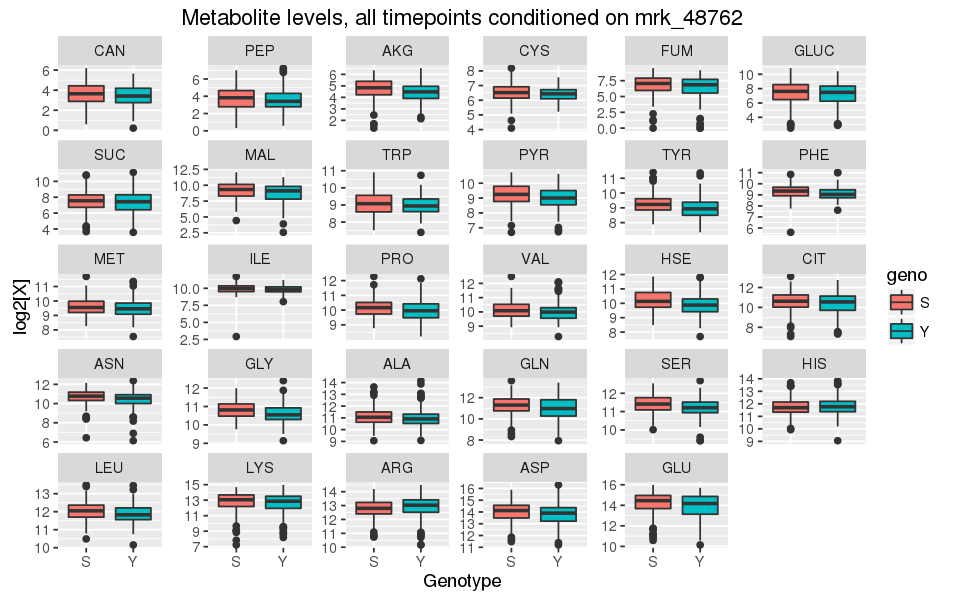

In [6]:
# plot
options(repr.plot.height = 5)
options(repr.plot.width = 8)
p <- ggplot(data2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, scales = "free_y") + 
    labs(title = paste("Metabolite levels, all timepoints conditioned on", thismrk), 
         y = "log2[X]", x = "Genotype") 
p

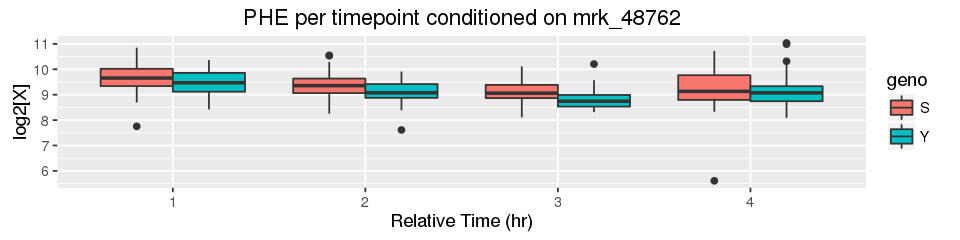

In [9]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p <- ggplot(data2plot %>% filter(metabolite %in% "PHE"), aes(factor(time), value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    labs(title = paste("PHE per timepoint conditioned on", thismrk), 
         y = "log2[X]", x = "Relative Time (hr)") 
p

In [10]:
Mmrk_dif_sig = data2plot %>% filter(metabolite %in% "PHE") %>% group_by(metabolite, time) %>% do({
    data = .
    sparent = data[data$geno=="S","value"]
    yparent = data[data$geno=="Y","value"]
    test = t.test(sparent$value, yparent$value)
    pval = test$p.value
    return(data.frame(pval))
})
Mmrk_dif_sig$pval = p.adjust(Mmrk_dif_sig$pval,method="BH")
Mmrk_dif_sig$mlog10.pval = -log10(Mmrk_dif_sig$pval)
#Mmrk_dif_sig = acast(Mmrk_dif_sig, metabolite ~ time, value.var = "pval")

Mmrk_dif_sig

,metabolite,time,pval,mlog10.pval
1,PHE,1,0.1228361,0.910674
2,PHE,2,0.01353246,1.868623
3,PHE,3,0.0004475488,3.34916
4,PHE,4,0.6744892,0.171025


### IMPORTANT: Significant difference in PHE levels across strains conditioned on chrXV:984992..984992 only at 2/4 time points!!

## Expression levels conditioning on PYK2 SNP @ chrXV:984992..984992

In [11]:
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

trx2plot = merge(trx_df,genotype,by = "strain")
trx2plot = trx2plot[!is.na(trx2plot$geno),]

### PYK2 itself

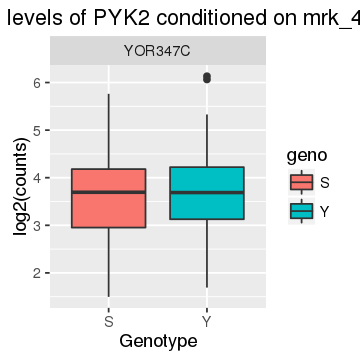

In [12]:
options(repr.plot.width = 3)
options(repr.plot.height = 3)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% "YOR347C") %>% group_by(name, strain) %>% 
    do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Transcript levels of PYK2 conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

### Highly correlated mQTL-eQTL profiles, cor > 0.5

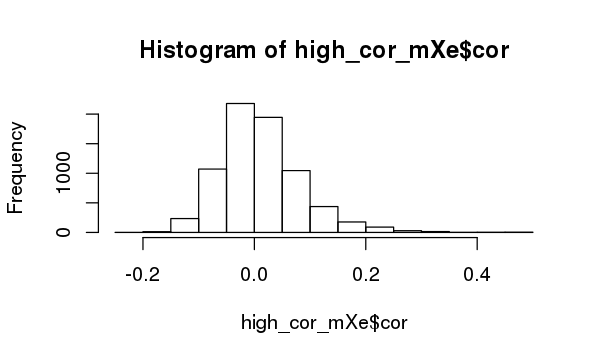

In [13]:
high_cor_mXe = mQTL_eQTL_cor %>% filter(metabolite == "PHE")
options(repr.plot.width = 5)
options(repr.plot.height = 3)
hist(high_cor_mXe$cor)
gnames = high_cor_mXe[order(high_cor_mXe$cor, decreasing = T),]
gnames = gnames %>% filter(cor >= quantile(high_cor_mXe$cor,probs=.995,na.rm=T))
gnames = gnames$gene

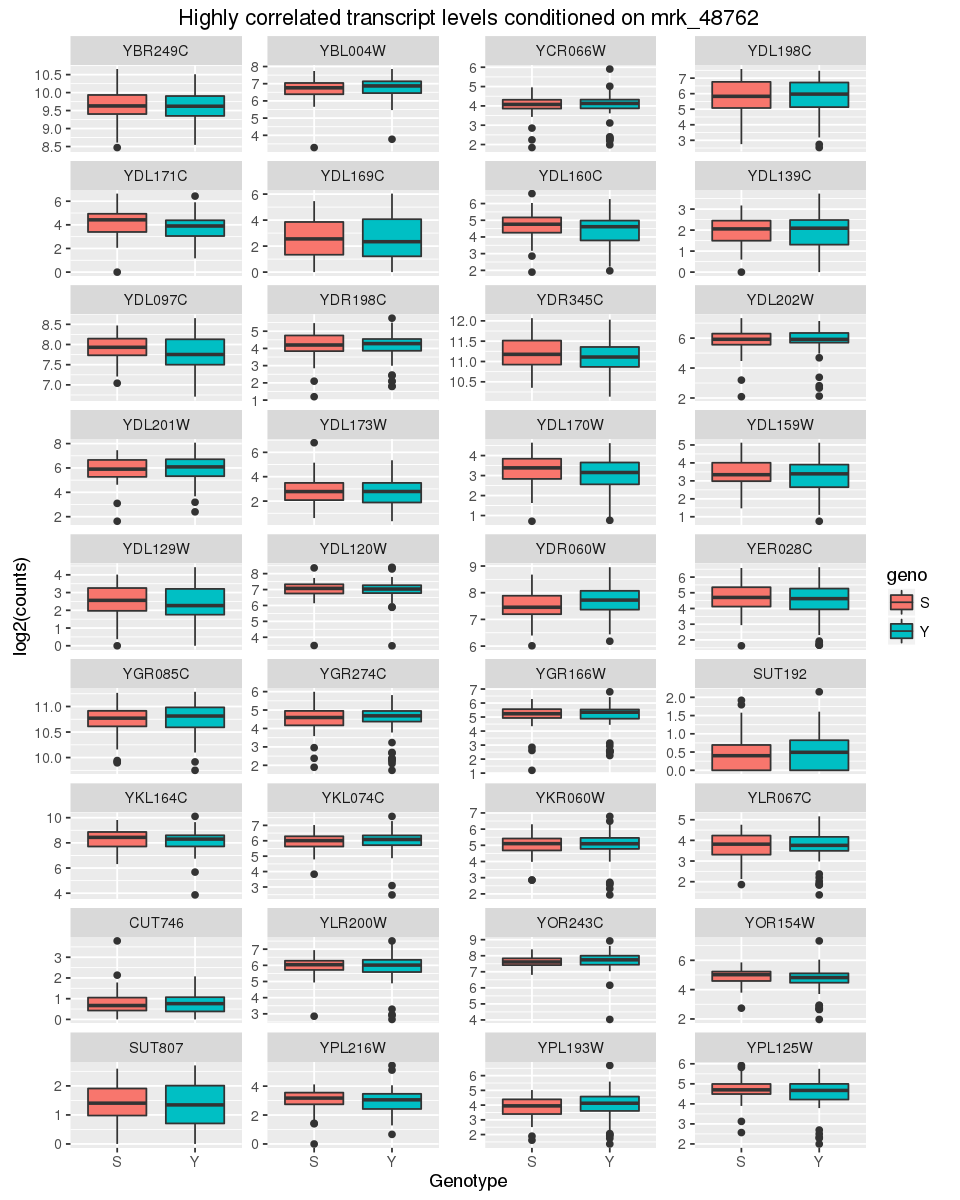

In [14]:
options(repr.plot.width = 8)
options(repr.plot.height = 10)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% gnames) %>% group_by(name, strain) %>% do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Highly correlated transcript levels conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

# Conclusions

Weak evidence for PHE-mQTL given variation at PYK2. Proceed with validation at your own risk.